In [109]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from common.clustering import k_means_multiple_dim_clustering, plot_2d_data_with_clusters, \
    plot_means_in_clusters_for_given_column
from common.outliers import find_outliers_in_multiple_columns, drop_outliers_from_dataset
from common.standardization import standardize, de_standardize

matplotlib.rcParams['figure.figsize'] = [7, 7]

### Constants and settings

In [110]:
columns_used_for_clustering = ["User_Score", "Critic_Score", "EU_Sales", "NA_Sales", "JP_Sales"]
categorical_columns = ["Platform", "Genre"]

### Load dataset from file
Please note that the `_preprocessed` file is required. To use this notebook
properly, please execute the preprocessing one first to generate proper dataset
file.

In [111]:
data = pd.read_excel("../data/games_sales_2016_preprocessed.xlsx", index_col=0)
data = data.filter(items=[*columns_used_for_clustering, *categorical_columns])

### Data stats for each column

In [112]:
stats_to_compute = ["max", "min", "std", "mean", "median"]
columns_stats = data.agg({item: stats_to_compute for item in columns_used_for_clustering})
print(columns_stats.to_string())

          User_Score  Critic_Score   EU_Sales   NA_Sales   JP_Sales
max     9.600000e+00     99.000000  28.960000  41.360000  10.220000
min     8.881784e-16     13.000000   0.000000   0.000000   0.000000
std     1.302502e+00     12.449681   0.622661   1.002670   0.385861
mean    7.270068e+00     70.942011   0.225307   0.402908   0.108312
median  7.500000e+00     72.400000   0.070000   0.170000   0.000000


### Data standardization

In [113]:
standardize(data, columns_used_for_clustering, columns_stats)

### Outliers detection

In [114]:
k_neighbours = 5
r_percentage = 0.02
outliers, non_outliers = find_outliers_in_multiple_columns(data, columns_used_for_clustering, k_neighbours, r_percentage)

## Clustering - 4 clusters
Here we perform clustering for the number of clusters equal to 2 - this is the number of clusters that gave us
the best results in the above analysis.

In [115]:
number_of_clusters = 4
data_without_outliers = drop_outliers_from_dataset(data, outliers)
clustered_data = k_means_multiple_dim_clustering(data_without_outliers, columns_used_for_clustering, number_of_clusters)
de_standardize(clustered_data, columns_used_for_clustering, columns_stats)

### Clustering results visualisation

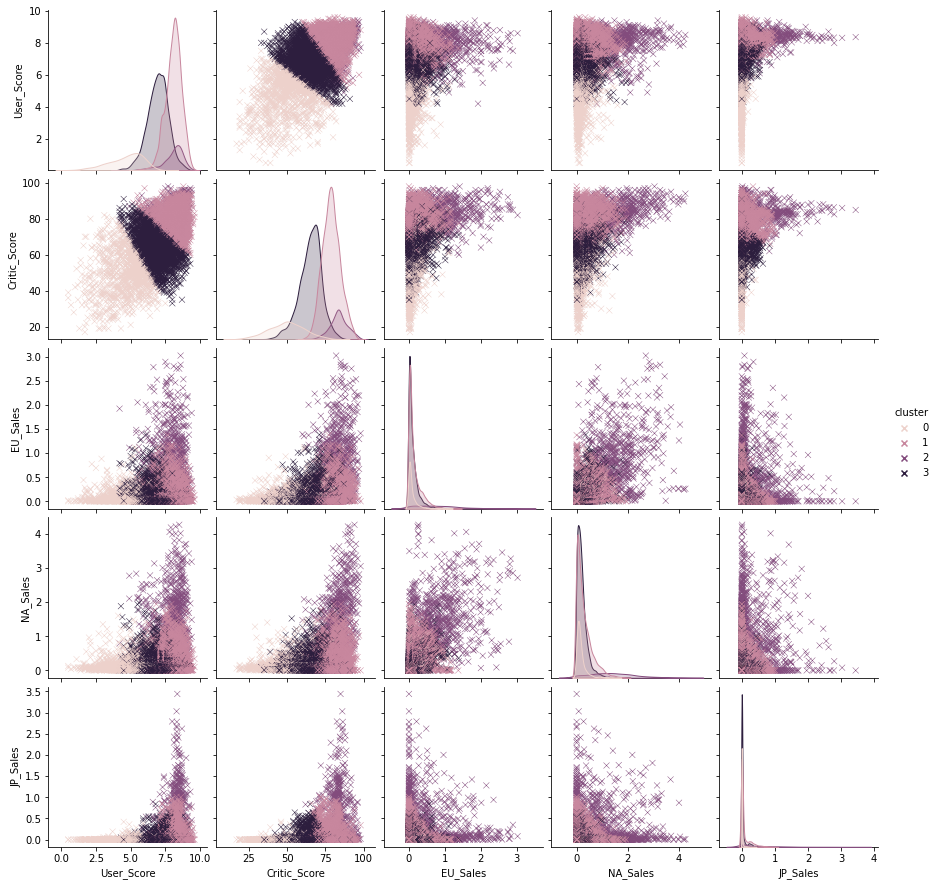

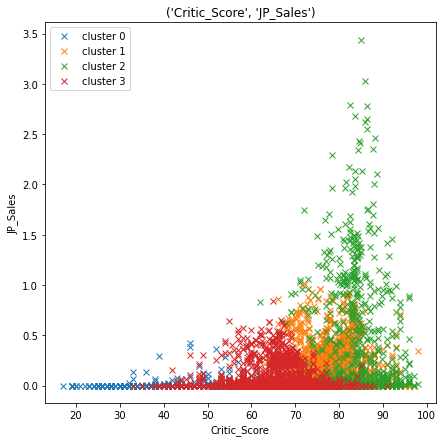

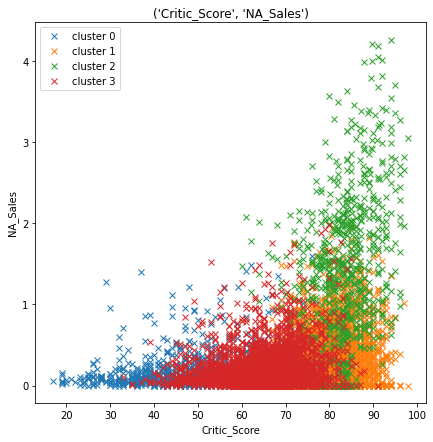

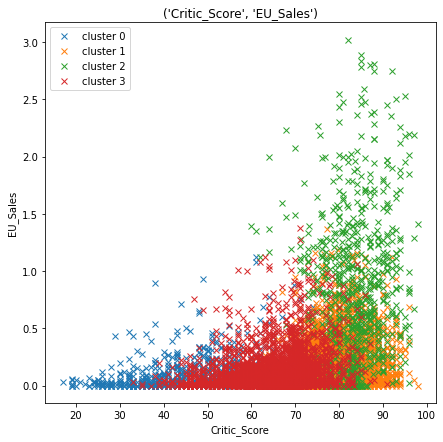

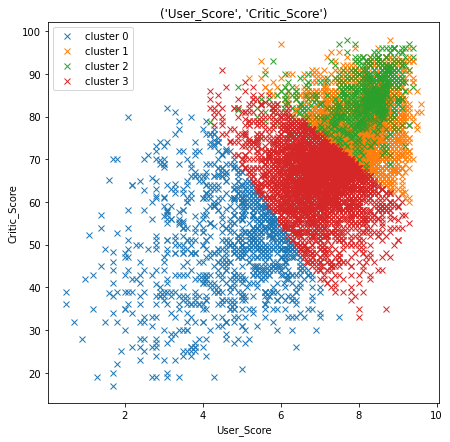

In [116]:
sns.pairplot(data=clustered_data, hue="cluster", markers=['x', 'x', 'x', 'x'])
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "JP_Sales"))
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "NA_Sales"))
plot_2d_data_with_clusters(clustered_data, ("Critic_Score", "EU_Sales"))
plot_2d_data_with_clusters(clustered_data, ("User_Score", "Critic_Score"))

### Clustering results visualisation using PCA

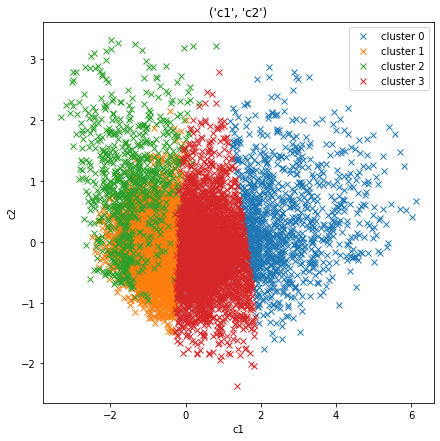

In [117]:
standardize(clustered_data, columns_used_for_clustering, columns_stats)
pca = PCA(n_components=2).fit(clustered_data.filter(columns_used_for_clustering))
reduced = pd.DataFrame(pca.transform(clustered_data.filter(columns_used_for_clustering)), columns=["c1", "c2"], index=clustered_data.index)
reduced.insert(2, "cluster", clustered_data["cluster"])
plot_2d_data_with_clusters(reduced, ("c1", "c2"))
de_standardize(clustered_data, columns_used_for_clustering, columns_stats)

### Clustering analysis - variable distribution for each cluster

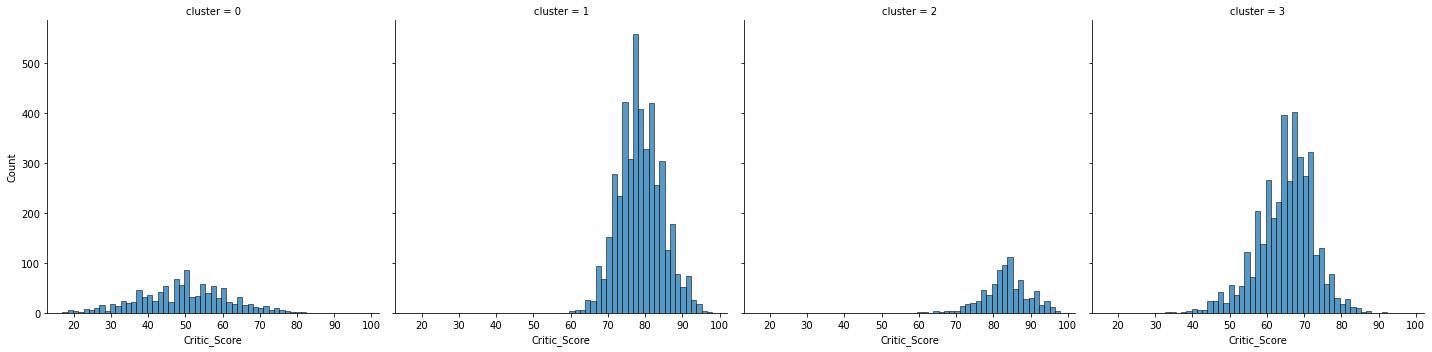

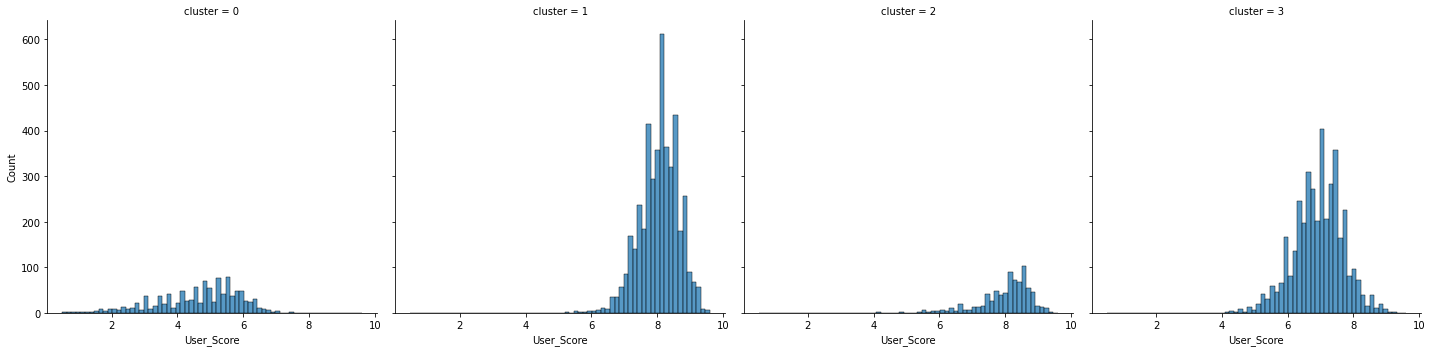

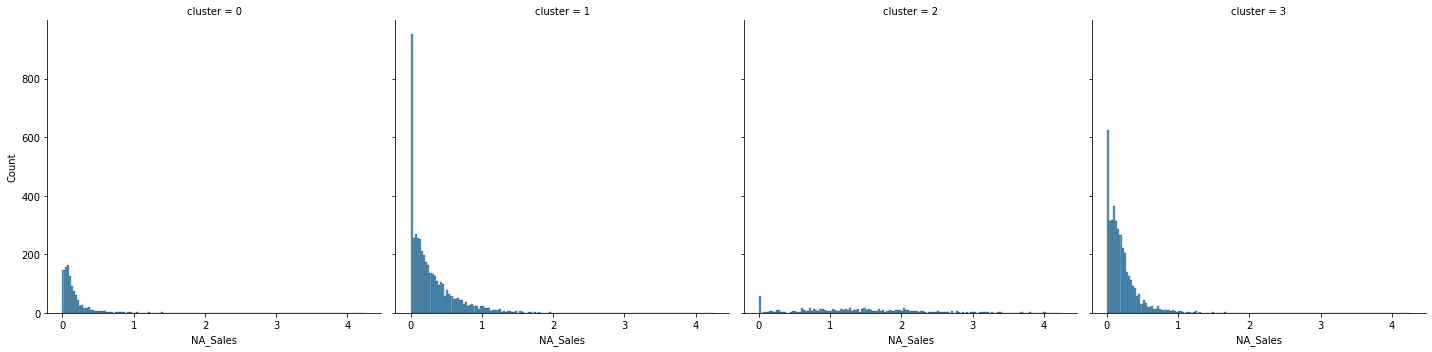

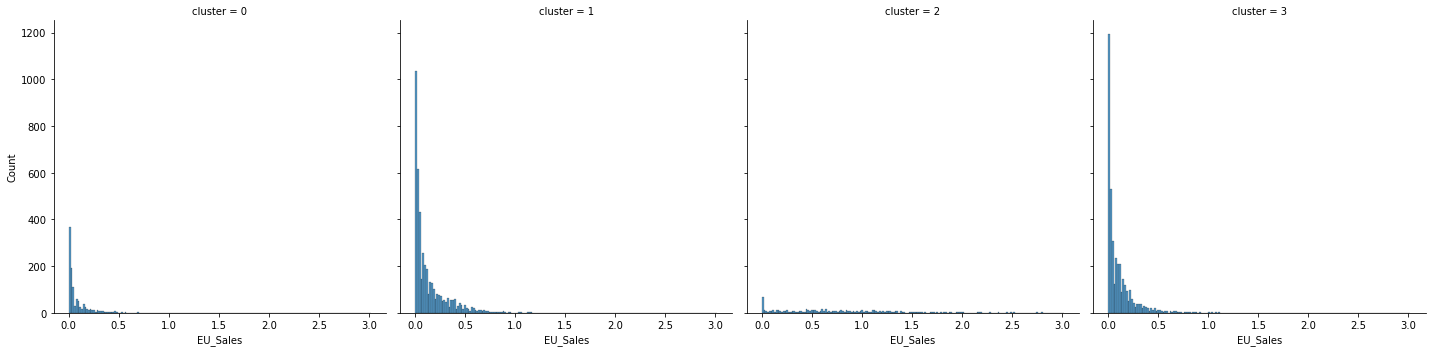

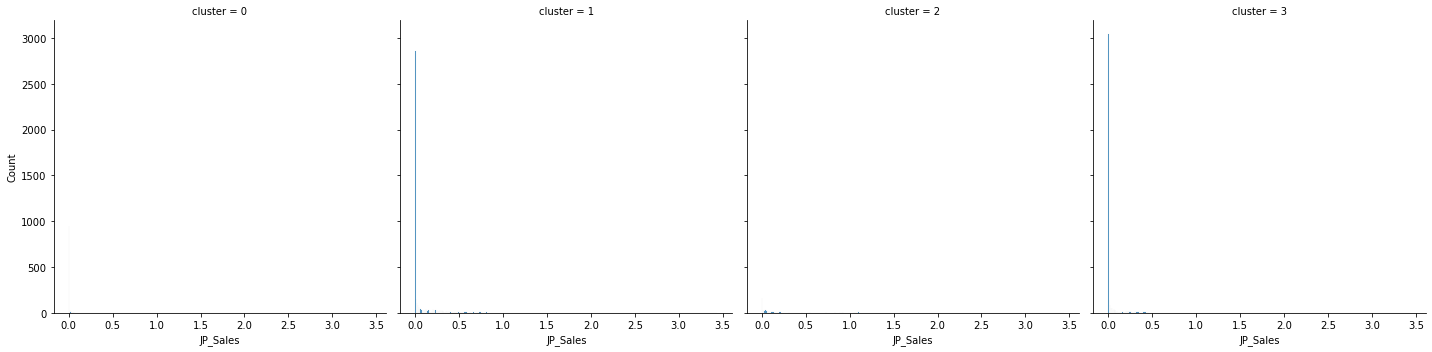

In [118]:
sns.displot(clustered_data, x="Critic_Score", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="User_Score", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="NA_Sales", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="EU_Sales", col="cluster", multiple="dodge")
sns.displot(clustered_data, x="JP_Sales", col="cluster", multiple="dodge")

### Clusters analysis - variables means for each cluster

         User_Score  Critic_Score  EU_Sales  NA_Sales  JP_Sales
cluster                                                        
0          4.650093     49.632992  0.083430  0.167931  0.007092
1          8.064334     78.633228  0.141369  0.280923  0.077204
2          8.028114     83.386582  0.805519  1.390101  0.444633
3          6.941737     65.036770  0.107659  0.204703  0.032636


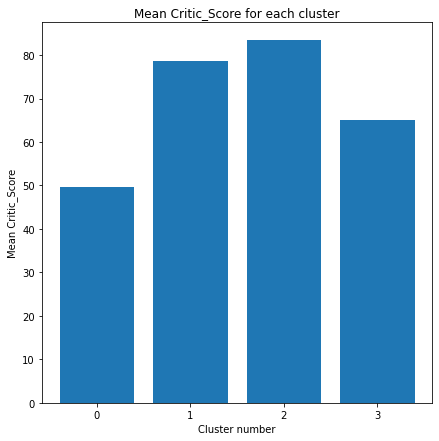

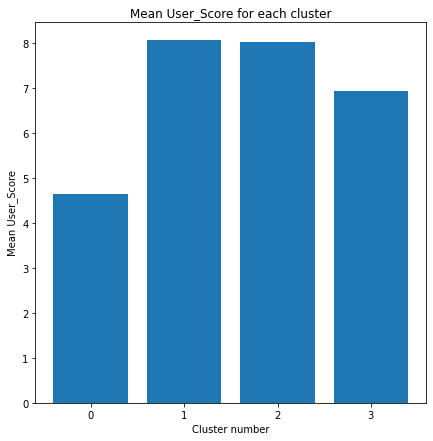

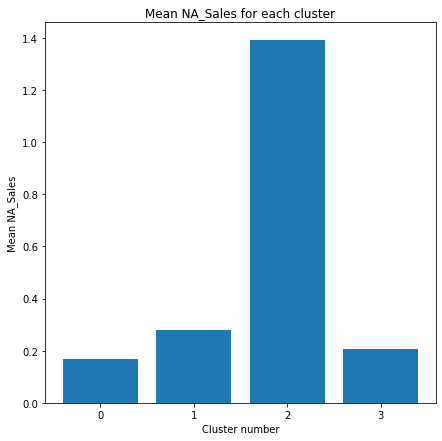

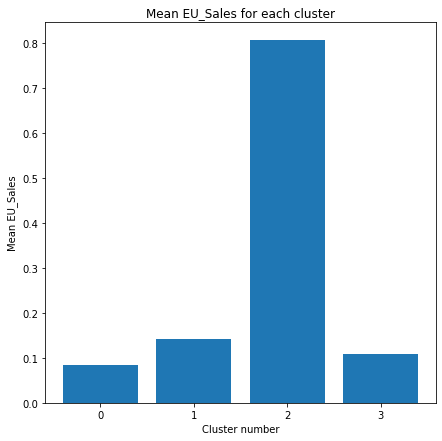

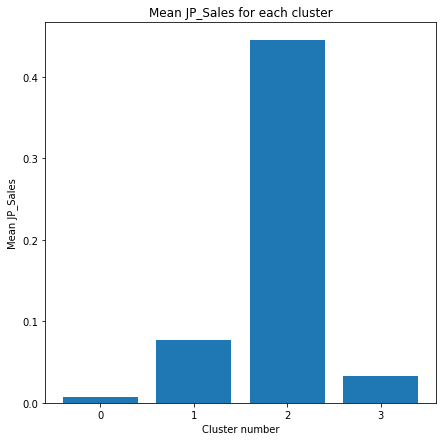

In [119]:
data_means_grouped_by_clusters = clustered_data.groupby("cluster").mean()
print(data_means_grouped_by_clusters)

plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "Critic_Score")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "User_Score")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "NA_Sales")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "EU_Sales")
plot_means_in_clusters_for_given_column(clustered_data, data_means_grouped_by_clusters, "JP_Sales")

### Clusters analysis - categorical variables

<AxesSubplot:xlabel='counts', ylabel='Platform'>

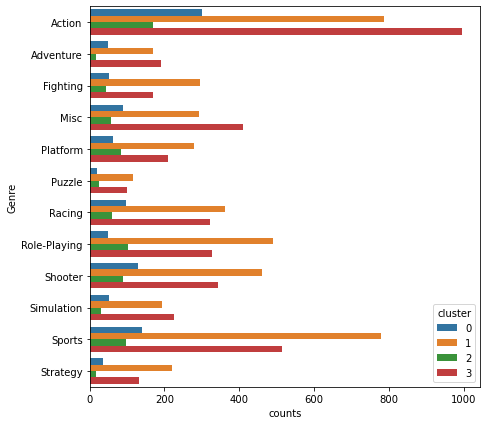

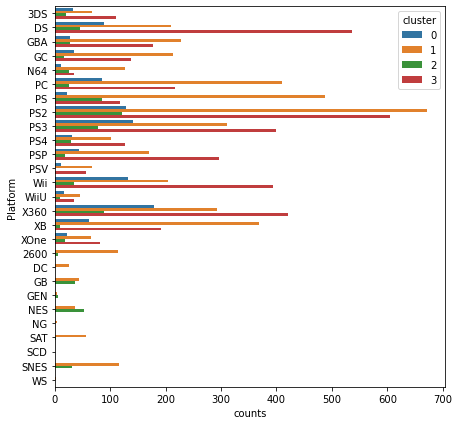

In [120]:
# genres
grouped_by_genre = clustered_data.groupby(["cluster", "Genre"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Genre", hue="cluster", data=grouped_by_genre, orient='h')

# platforms
grouped_by_platform = clustered_data.groupby(["cluster", "Platform"]).size().reset_index(name='counts')
plt.figure()
sns.barplot(x="counts", y="Platform", hue="cluster", data=grouped_by_platform, orient='h')